In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import v2
import os
from PIL import Image

In [2]:
train_dir = "data/train"
test_dir = "data/test"

to_tensor = v2.ToTensor()

mean = torch.zeros(1)
std = torch.zeros(1)
num_images = 0


for root in [train_dir,test_dir]:
    for subdir, _, files in os.walk(root):
        for file_name in files:
            if file_name.lower().endswith('.jpg'):
                img_path = os.path.join(subdir, file_name)
                try:
                    img = Image.open(img_path).convert('L')
                    tensor = to_tensor(img)  # [C, H, W]
                    mean += tensor.mean(dim=[1, 2])
                    std += tensor.std(dim=[1, 2])
                    num_images += 1
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")

if num_images == 0:
    raise ValueError("No image found")

mean /= num_images
std /= num_images

print(f"Mean: {mean}")
print(f"Std:  {std}")
print(f"Images number: {num_images}")

/home/vadimpp/.local/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Mean: tensor([0.5074])
Std:  tensor([0.2121])
Images number: 35887


In [3]:
from torch.utils.data import DataLoader, Dataset
import json

class FER_dataset(Dataset):
    def __init__(self, img_dir, train = True, transforms = None):
        self.img_dir = os.path.join(img_dir, "train" if train else "test")
        self.transforms = transforms

        with open(os.path.join(img_dir,"format.json"),"r") as fm:
            self.format = json.load(fm)

        self.length = 0
        self.files = []
        self.targets = torch.eye(len(self.format.keys()))

        for _dir, _target in self.format.items():
            path = os.path.join(self.img_dir,_dir)
            list_files = os.listdir(path)
            self.length += len(list_files)
            self.files.extend(map(lambda _x: (os.path.join(path,_x),_target), list_files))
    
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        path_file, target = self.files[idx]
        t = self.targets[target]
        img = Image.open(path_file)

        if self.transforms:
            img = self.transforms(img)
        
        return img, t

In [4]:

tfr = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean = mean, std = std)
])
id_to_cl = {}
with open(os.path.join("./data","format.json"),"r") as fm:
    id_to_cl = {idx:cl for cl,idx in json.load(fm).items()}

train_ds = FER_dataset(img_dir = "./data", train=True, transforms=tfr)

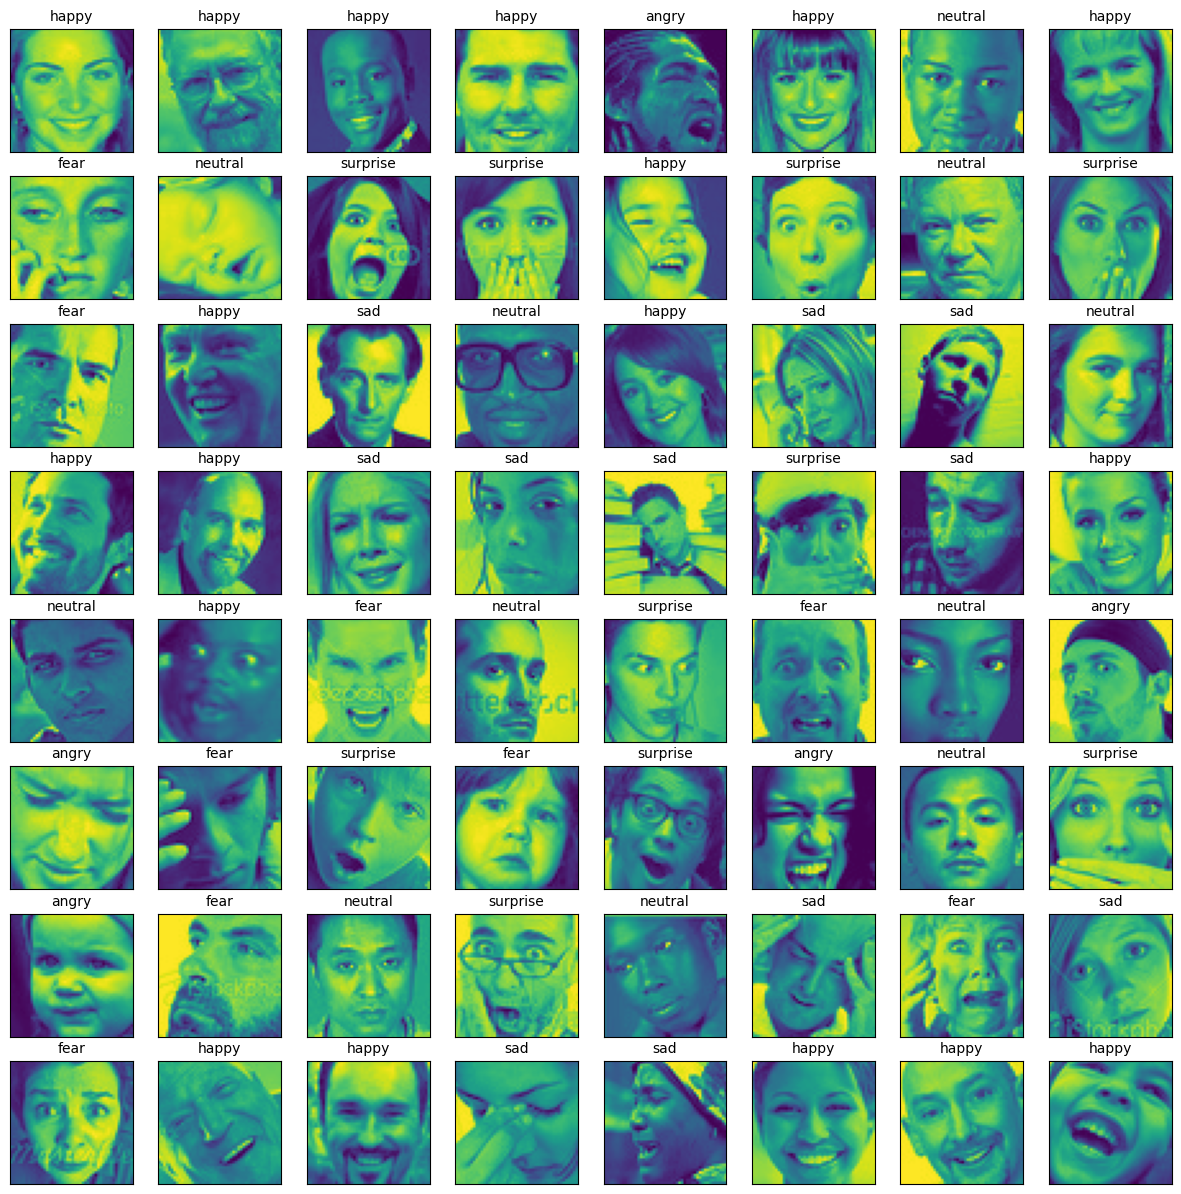

In [8]:
from random import randint

plt.figure(figsize = (15,15))

to_img = v2.ToPILImage()

for i in range(64):
    img, label = train_ds[randint(0,len(train_ds))]
    img = img.permute(1, 2, 0).numpy()
    img = img * std.numpy() + mean.numpy()              
    img = img.clip(0, 1)                

    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(id_to_cl[torch.argmax(label).item()],fontsize = 10)

    plt.imshow(img)
plt.show()